In [4]:
import numpy as np
import librosa
import matplotlib.pyplot as plt
import math
import random

## Working Up to DFT

### Let's work through some basic plotting

482549 3015 24127


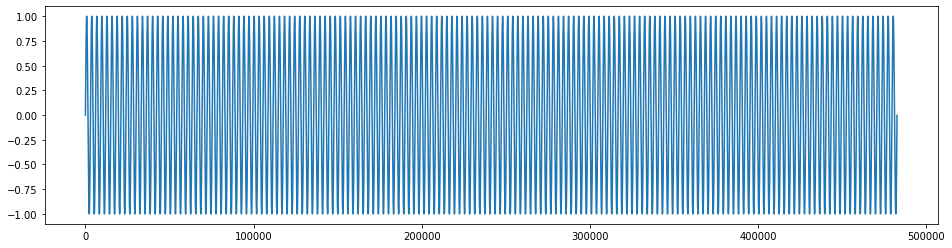

In [456]:
RAD = np.pi * 2
PERIODS = 8
INTERVALS = 20 # we can think of interval as seconds
TOTAL_PERIODS = PERIODS * INTERVALS
RESOLUTION = 3 # can be used to get additional steps in the graph / higher resolution
STEP_SIZE = 1 / (TOTAL_PERIODS * RESOLUTION)

rad_increments = np.arange(0, RAD * TOTAL_PERIODS, STEP_SIZE)

# make increments length rounded to nearest 100
#cut_off = rad_increments.shape[0] % 100
#rad_increments = rad_increments[:-cut_off]
TOTAL_RAD_INCREMENTS = rad_increments.shape[0]
RAD_INCREMENTS_PER_PERIOD = TOTAL_RAD_INCREMENTS // TOTAL_PERIODS
RAD_INCREMENTS_PER_INTERVAL = TOTAL_RAD_INCREMENTS // INTERVALS
print(TOTAL_RAD_INCREMENTS, RAD_INCREMENTS_PER_PERIOD, RAD_INCREMENTS_PER_INTERVAL)

signal = np.sin(rad_increments)

# plot over time
plt.figure(figsize=(16,4))
plt.plot(signal);

> Let's first plot the signal rotating around (0,0), with a red dot for the average of all the plot points

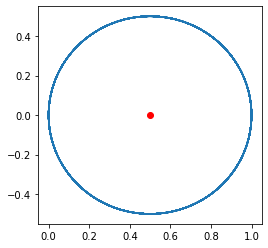

In [457]:
INTERVALS_PER_SAMPLE = 1

sample_size = RAD_INCREMENTS_PER_INTERVAL * INTERVALS_PER_SAMPLE

p_xs = np.sin(rad_increments[:sample_size]) * signal[:sample_size]
p_ys = np.cos(rad_increments[:sample_size]) * signal[:sample_size]
com_x, com_y = (p_xs.mean(), p_ys.mean())

plt.figure(figsize=(4,4))
plt.plot(p_xs, p_ys)
plt.plot(com_x, com_y, 'ro');


> now let's look at the signal plotted at a specific number of periods per cycle

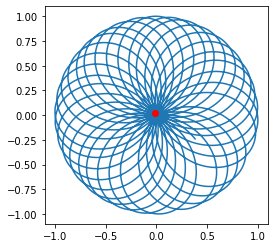

In [521]:
SAMPLE_PERIODS_PER_CYCLE = 11.34

def build_cycle_sample(periods_per_cycle:float, target_signal, intervals:float=INTERVALS, resolution:float=RESOLUTION):
    sample_size = periods_per_cycle * intervals * resolution
    sample_step_size = 1 / sample_size
    sample_rad_increments = np.arange(0, RAD * periods_per_cycle, sample_step_size)
    clip_size = sample_rad_increments.shape[0]

    q_xs = np.sin(sample_rad_increments) * target_signal[:clip_size]
    q_ys = np.cos(sample_rad_increments) * target_signal[:clip_size]
    q_com_x, q_com_y = (q_xs.mean(), q_ys.mean())
    
    return q_xs, q_ys, q_com_x, q_com_y

q_xs, q_ys, q_com_x, q_com_y = build_cycle_sample(SAMPLE_PERIODS_PER_CYCLE, signal)

plt.figure(figsize=(4,4))
plt.plot(q_xs, q_ys)
plt.plot(q_com_x, q_com_y, 'ro');


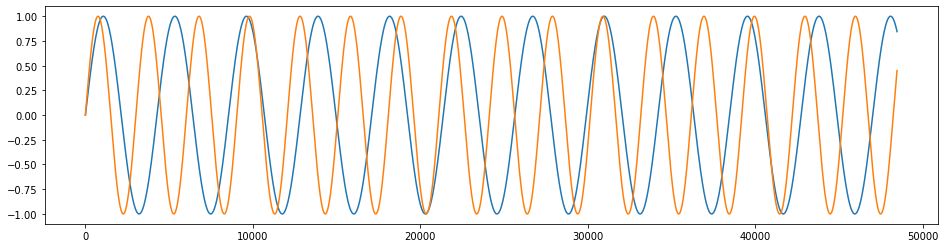

In [460]:
plt.figure(figsize=(16,4))
plt.plot(np.sin(sample_rad_increments));
plt.plot(signal[:clip_size]);

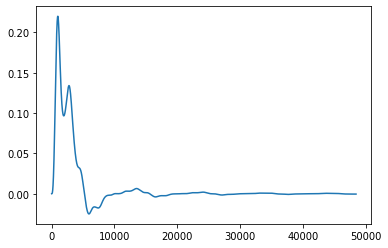

In [522]:
# Let's get the rolling average for the center point of this signal
def rolling_average(x):
    result = []
    for i in range(1, x.shape[0]):
        result.append(x[:i].mean())
    return np.array(result)

plt.plot(rolling_average(q_xs) * rolling_average(q_ys))

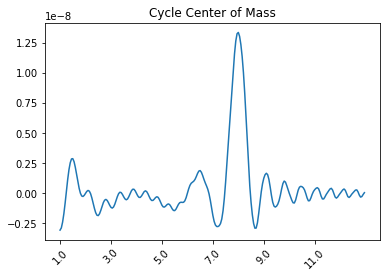

In [523]:
'''
Now, we will try and figure out which period is associated with our signal.
Let's step through the periods 1 -> 13 in increments of 0.05 and get the 
average of all vectors for that signal.
'''
coms = []
l = np.arange(1, 13, 0.05)
for x in l:
    _, _, com_x, comy = build_cycle_sample(x, signal)
    coms.append(com_x * com_y)

coms = np.array(coms)
plt.plot(coms)
tick_positions = range(0, len(l), 40)
tick_labels = [f'{l[xx]:.1f}' for xx in tick_positions]
plt.xticks(tick_positions, tick_labels, rotation=45);
plt.title("Cycle Center of Mass");

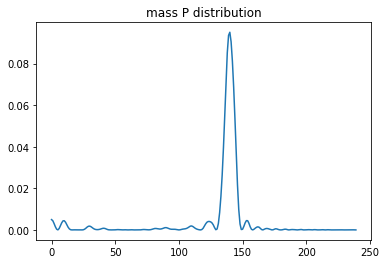

In [524]:
# now let's normalize and then convert to distribution
dist = coms**2/(coms**2).sum()
plt.plot(dist)
plt.title("mass P distribution");

In [525]:
# which period is associated most closely with our sampling.
l[np.argmax(dist)]

8.000000000000007

5.0


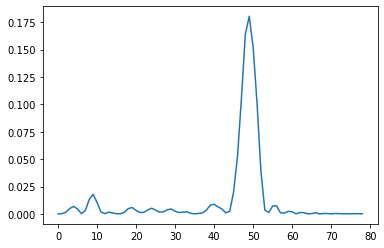

In [544]:
def almost_fourier_transform(target_signal:np.array, start:float, stop:float, step:float, intervals:float, resolution:float=RESOLUTION):
    coms = []
    steps = np.arange(start, stop, step)
    for s in steps:
        _, _, com_x, comy = build_cycle_sample(s, target_signal, intervals, resolution)
        coms.append(com_x * com_y)
    coms = np.array(coms)
    dist = coms**2/(coms**2).sum()
    return steps[np.argmax(dist)], steps, dist, coms


def build_signal(p:float, i:float, r:float=RESOLUTION):
    step_size = 1 / (p * i * r)
    rad_inc = np.arange(0, RAD * p * i, step_size)
    return np.sin(rad_inc)

new_interval = 10
new_period = 5
new_resolution = 3
new_signal = build_signal(new_period, new_interval)
p, s, d, c = almost_fourier_transform(new_signal, 0.1, 8, 0.1, new_interval)
print(p)
plt.plot(d);

### Rewriting and moving forward

Okay, now that I understand the concept roughly, let's rewrite some stuff and start again.

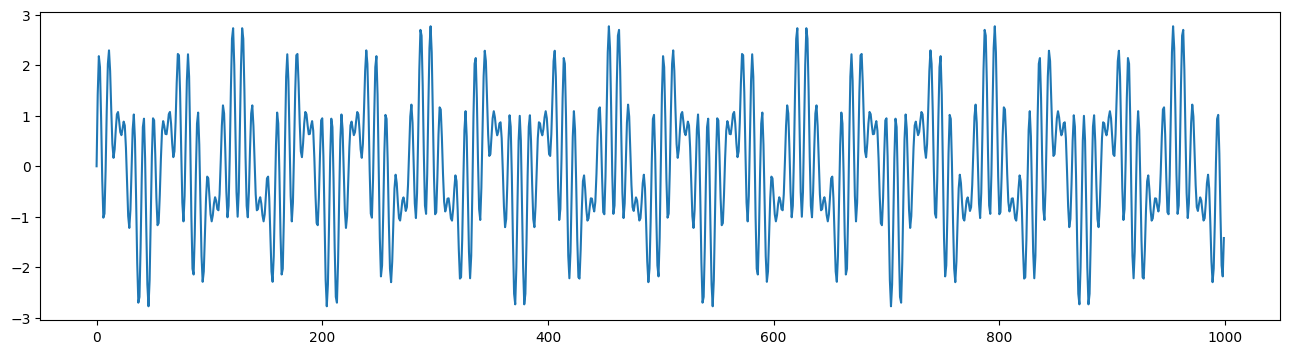

In [5]:
def build_signal(hz:float, seconds:float=2., resolution:int=1000):
    
    total_periods =  hz * seconds
    total_rad = math.pi * 2 * total_periods
    step_size = total_rad / resolution
    rad_inc = np.arange(0, total_rad, step_size)
    
    return np.sin(rad_inc)[:resolution]

def build_complex_signal(freqs:list, seconds:float=2., resolution:int=1000):
    x = np.zeros(resolution)
    for freq in freqs:
        x = x + build_signal(freq, seconds, resolution)
    return x

complex_signal = build_complex_signal([3, 21, 17], 6)

plt.figure(figsize=(16,4))
plt.plot(complex_signal);

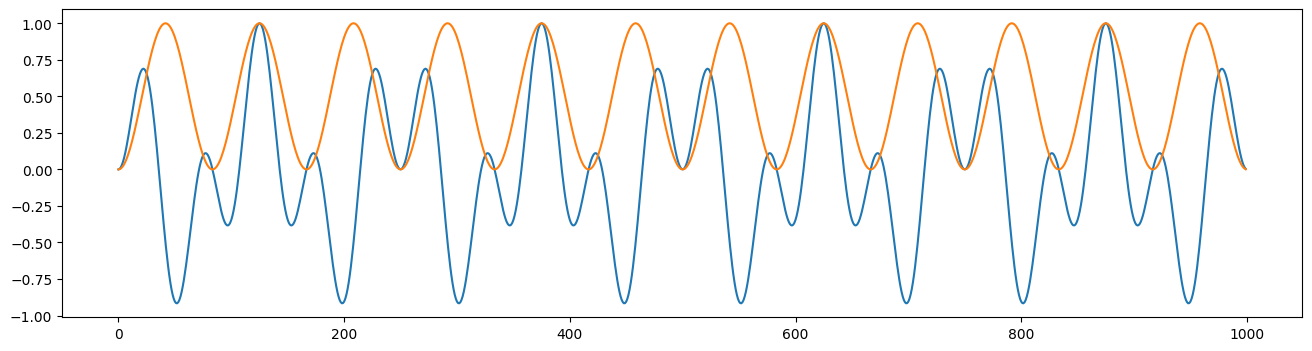

In [6]:
def get_frequency_resonance(target_signal:np.array, target_hz:float, seconds:float=2, resolution:float=1000):
    comparative_signal = build_signal(target_hz, seconds, resolution)
    q_xs = comparative_signal * target_signal
    
    return q_xs.mean(), q_xs

r0, x0 = get_frequency_resonance(build_signal(7), 3)
r1, x1 = get_frequency_resonance(build_signal(3), 3)
plt.figure(figsize=(16,4))
plt.plot(x0)
plt.plot(x1);

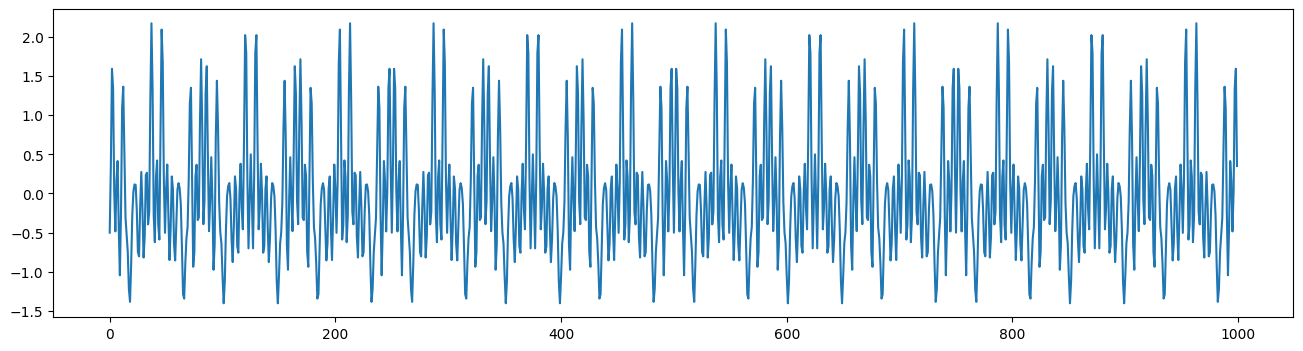

In [7]:
r0, x0 = get_frequency_resonance(complex_signal, 17, 6)
plt.figure(figsize=(16,4))
plt.plot(x0 - r0);

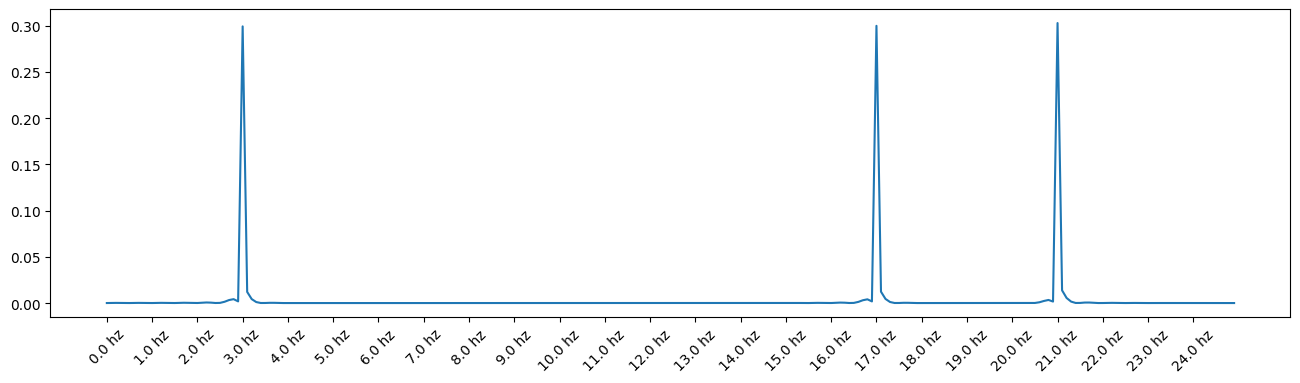

In [8]:
def shoddy_fourier_transform(
    target_signal:np.array, 
    start_freq:float, 
    stop_freq:float, 
    step_size:float, 
    seconds:float=2, 
    resolution:float=1000
):
    coms = []
    steps = np.arange(start_freq, stop_freq, step_size)
    for f in steps:
        r, _ = get_frequency_resonance(target_signal, f, seconds, resolution)
        coms.append(r)
    coms = np.array(coms)
    dist = coms**2/(coms**2).sum()
    return dist, coms, steps

def render_ft_chart(d, c, s, tf=10):
    plt.figure(figsize=(16,4))
    plt.plot(d);
    tick_positions = range(0, len(s), tf)
    tick_labels = [f'{s[xx]:.1f} hz' for xx in tick_positions]
    plt.xticks(tick_positions, tick_labels, rotation=45);
    plt.show()
    
d, c, s = shoddy_fourier_transform(complex_signal, 0.01, 25, .1, 6)
render_ft_chart(d, c, s)

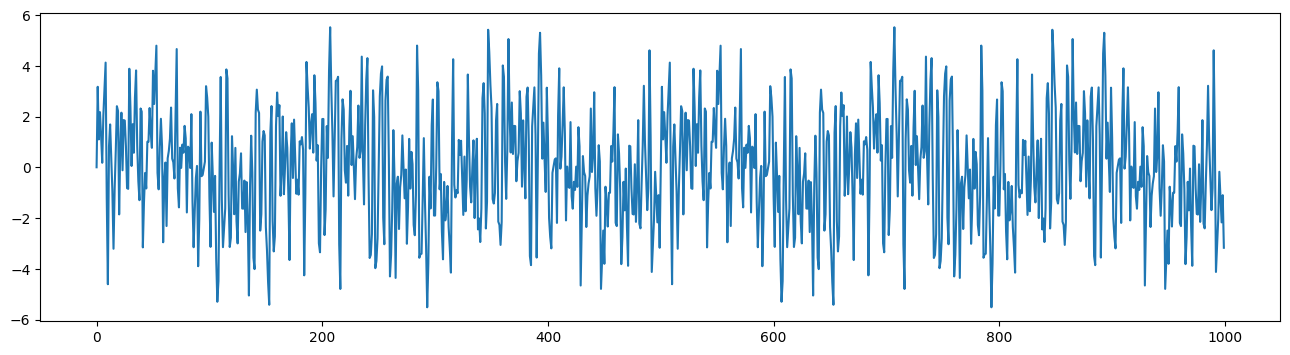

In [9]:
very_complex_signal = build_complex_signal([143, 32, 192, 78, 522, 388, 423, 92, 3, 88])
plt.figure(figsize=(16,4))
plt.plot(very_complex_signal);

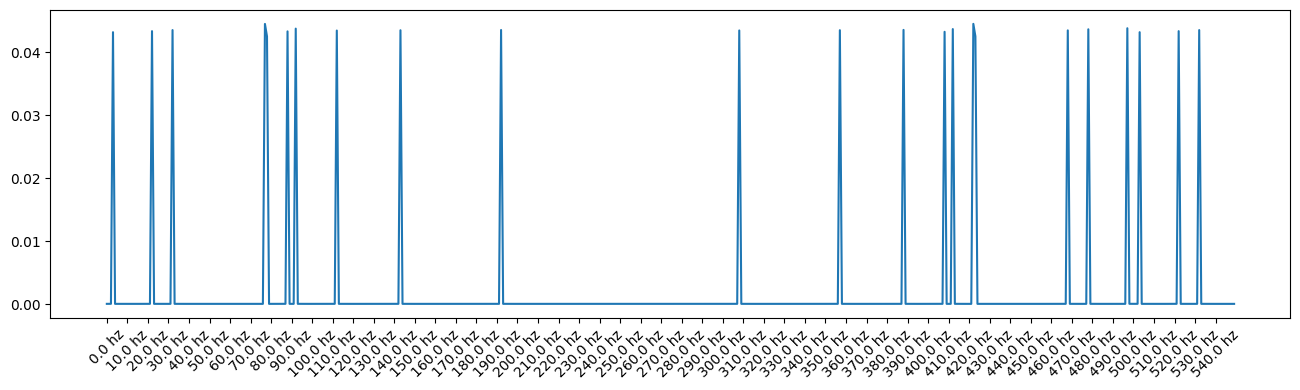

In [10]:
d, c, s = shoddy_fourier_transform(very_complex_signal, 0.01, 550, 1.)
render_ft_chart(d, c, s)

Now, let's think about the "winding of the signal", what I've called `get_frequency_resonance`, as $g(t)e^{-2\pi{ift}}$ where $g(t)$ is the intensity of the target signal at timestep $t$, and $f$ is the target pure frequency we are comparing to.  This means the center of mass we were calulcating above would be:

$\hat{g}(f) = \frac{1}{N}\sum_{k=0}^{N}g(t_k)e^{-2\pi{ift_k}}$

Wheren N is the number of sampling points and the center of mass is represented as a complex number.  In the limit:

$\hat{g}(f) = \frac{1}{t_2-t_1}\int_{t_1}^{t_2}g(t)e^{-2\pi{ift}}dt$

Where $t_2-t_1$ is the size of the time interval we are looking at.  In practice, we don't divide out for the fourier transform (i.e. $\frac{1}{t_2-t_1}$), and only use the intergal portion of the equation.

In terms of implementation, we can think of the Discrete fourier transform as the dot product between a target frequency sampled at some interval and the input frequency (that interval is the sampling rate of the input frequency), and we use some broadcasting magic to make it work.  We also use complex number to represent the vector of dot product.

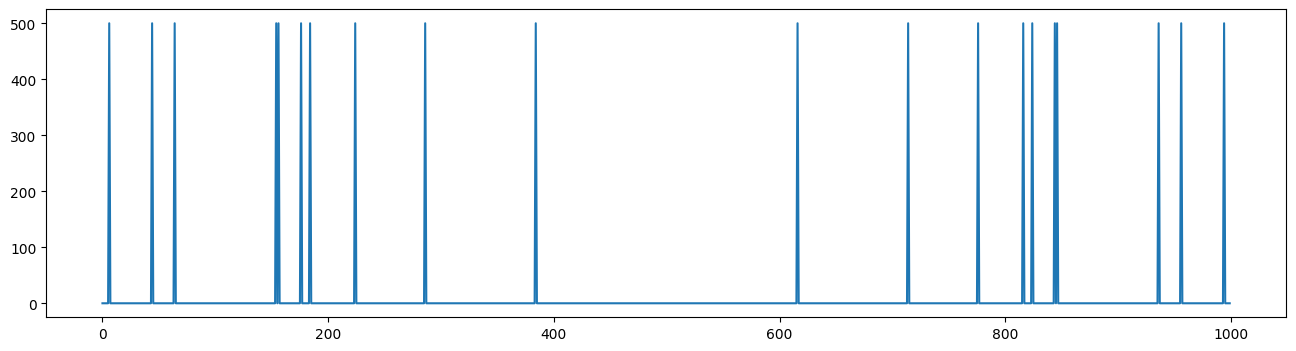

In [114]:
def discrete_fourier_transform(x):
    T = x.shape[0]
    t = np.arange(T)
    k = t.reshape((T, 1))
    M = np.exp(-2j * np.pi * k * t / T)
    return M @ x

def polar_form(xs):
    return np.sqrt(xs.real**2 + xs.imag**2)

s = build_complex_signal([143, 32, 192, 78, 522, 388, 423, 92, 3, 88], 2, 1000)
r = discrete_fourier_transform(s)
plt.figure(figsize=(16,4))
plt.plot(polar_form(r));

## Looking towards Short-time Fourier Transform

So, next thing to focus on is STFT.  For this, we'll look at smaller windows of the signal and apply our fourier transform.  To get a window, we take a section $s$ of our signal $S$ and apply a window function, so something like $x_w(s) = x(s) * w(s)$.  As an example of a windowing function, we can think of a rectangular windowing function as a mask of 0's and ones:

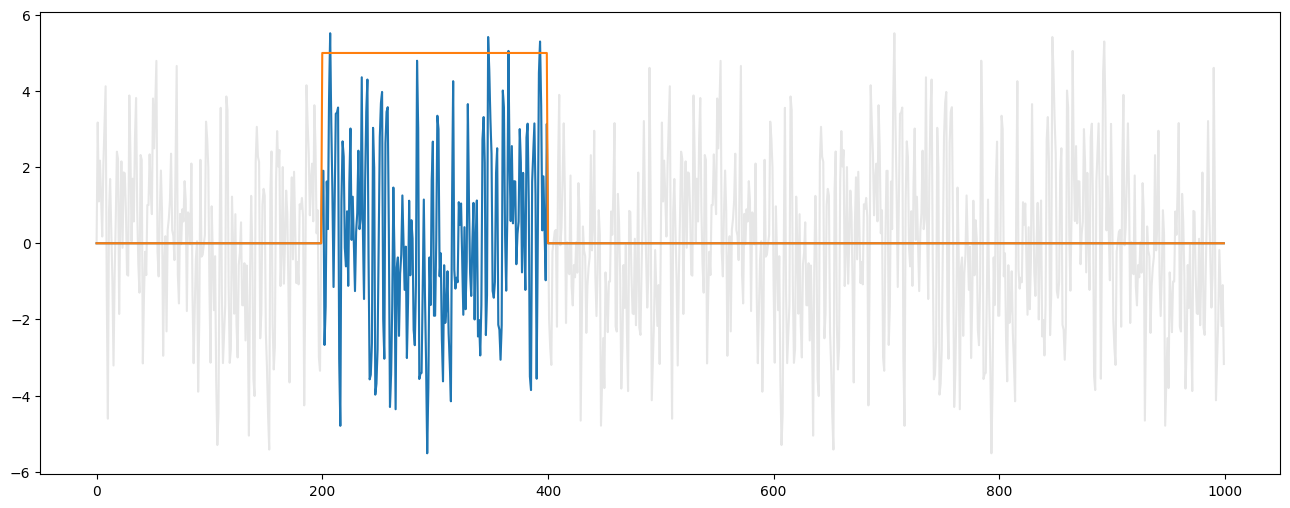

In [31]:
def rectangular_window(x:np.array, window_size:int, window_offset:int):
    window = np.arange(x.shape[0])
    lw = (window >= window_offset).astype(float)
    rw = (window < window_offset + window_size).astype(float)
    window = lw + rw - 1
    return x * window, window

ws, w = rectangular_window(very_complex_signal, 200, 200)

plt.figure(figsize=(16,6))
plt.plot(very_complex_signal, color=(0.9, 0.9, 0.9));
plt.plot(ws);
plt.plot(w * 5);

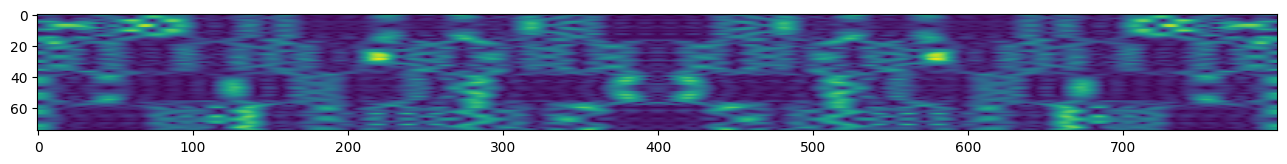

In [73]:
def stft(target_signal:np.array, window_size:int, hop_size:int, window_func:callable=None):
    window_func = rectangular_window if window_func is None else window_func
    result = []
    # we'll just pretend the window and frame are the same size since they usually are
    for i in range(window_size, target_signal.shape[0], hop_size):
        windowed_signal, window = window_func(target_signal, window_size, i - window_size)
        r = discrete_fourier_transform(windowed_signal)
        result.append(polar_form(r))
    # note, haven't removed symmetry
    return np.array(result)

sig = None
for i in range(1, 5):
    freqs = [random.randint(1, 1000) for x in range(20)]
    next_sig = build_complex_signal(freqs, 1, 200)
    sig = next_sig if sig is None else np.concatenate((sig, next_sig))

r = stft(sig, 50, 10)
plt.figure(figsize=(16,6))
plt.imshow(r);

In [97]:
sr = 400
audio, _ = librosa.load('../data/taunt.wav', sr=sr)

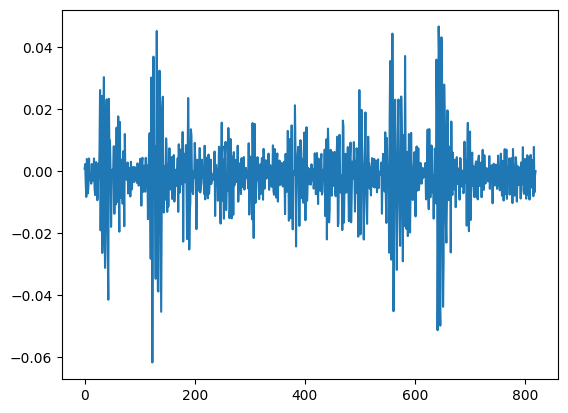

In [94]:
plt.plot(audio)

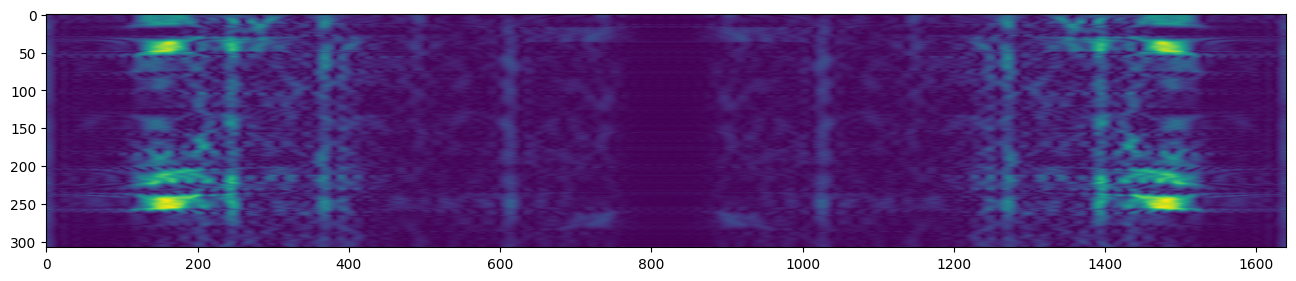

In [101]:
audio_spec = stft(audio, 100, 5)
plt.figure(figsize=(16,6))
plt.imshow(audio_spec);

(1467,)

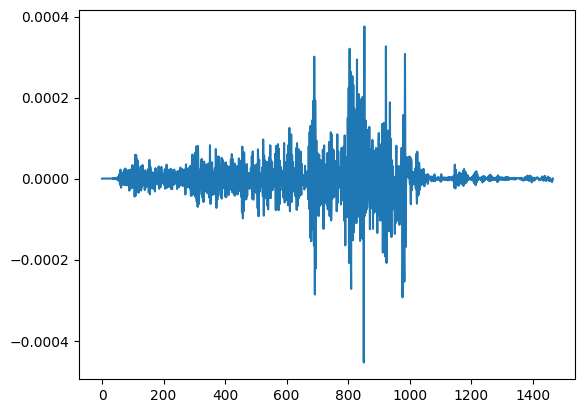

In [117]:
song, sr = librosa.load('../data/song.mp3', sr=20)
plt.plot(song)
song.shape

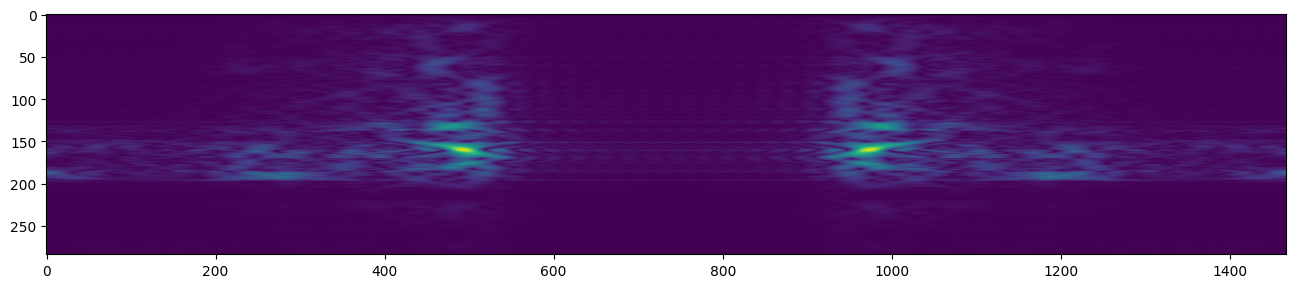

In [122]:
audio_spec = stft(song, 50, 5)
plt.figure(figsize=(16,8))
plt.imshow(audio_spec);

In [125]:
import IPython.display as ipd

ipd.Audio(song, sr=20)

TypeError: Audio.__init__() got an unexpected keyword argument 'sr'